In [1]:
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# custom packages
from Dissertation import RandomGenerator, convert_to_int, get_order_index
from utils import *
from estimators import ClusteredSegmentation
# scipy
import scipy
from scipy.sparse import vstack, identity, csr_array, vstack, csc_matrix
from scipy.sparse.linalg import svds, inv
from scipy.stats import f, ncf
from scipy.spatial.distance import mahalanobis, euclidean
# sklearn
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
# others
from tqdm.notebook import trange
from itertools import combinations, starmap
from functools import partial

In [2]:
rg = RandomGenerator(10, 20_000, order_by = 'var', use_dask = False, verbose= False)
X = rg._X.loc[:,rg._X.columns.str.contains('X')].apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
y = rg()['y'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  .20)
cluster = ClusteredSegmentation(n_clusters = 10)
cluster.fit(X, y)
tau = cluster.tau_metric
y_pred_exist = []
y_test_exist = []
for i, x in enumerate(X_test.reshape(-1)):
    try:
        y_pred_exist.append(cluster.predict(x))
        y_test_exist.append(y_test[i][0])
    except:
        pass
test_r2 = r2_score(y_test_exist, y_pred = y_pred_exist)

In [3]:
tau.r_sqf, tau.r_sqr, test_r2, tau.tau_est, tau.tau_LB

(0.971068316029621,
 0.9454114868966641,
 0.9436452058295918,
 0.8868073202799029,
 0.7655649895043438)

In [4]:
rg.config.parameter_size

172

### Barcode Scanner

In [5]:
class barcodeScanner:
    def __init__(self, estimator, config):
        self.config = config
        self.barcode_length = config.p
        if hasattr(estimator, "full_to_reduced"):
            self.segmentation_table = estimator.full_to_reduced.reset_index()
            self.num_clusters = estimator.n_clusters
            self.num_parameters_full = self.segmentation_table.shape[0]
            self.num_missing_pairs = 2**self.barcode_length - self.segmentation_table.shape[0]
            self.missing_pairs_decimal_repr = list(filter(lambda x: x not in self.segmentation_table.full, range(2**self.barcode_length)))
        else:
            raise AttributeError("'estimator' must have been fit and have 'full_to_reduced' attribute")
        self.var_names = [f"X_{i}" for i in range(self.barcode_length)]
        self.var_names_all = expand_var_names(self.var_names)
        
    def MLEscan(self):
        B = vstack([self.raw_contrast, scanner.missingPairsMLE()])
        proj = B.T @ inv(B @ B.T) @ B
    
    
    
    @property
    def raw_contrast(self):
        if hasattr(self, "raw_contrast_"):
            pass
        else:
            result = []
            for key in self.groupby_expanded_barcode.keys():
                result.append(self.gen_contrast(self.groupby_expanded_barcode[key]))
            self.raw_contrast_ = vstack(result)
            del result
        return self.raw_contrast_

    @staticmethod
    def gen_contrast(csc_matrix: scipy.sparse._csc.csc_matrix)-> scipy.sparse._csc.csc_matrix:
        fixed_array = csc_matrix.getrow(0)
        result = []
        for i in range(1, csc_matrix.shape[0]):
            result.append(fixed_array - csc_matrix.getrow(i))
        if len(result) > 0:
            return vstack(result)
        else:
            return None
    

    @property
    def groupby_expanded_barcode(self):
        if hasattr(self, "groupby_expanded_barcode_"):
            pass
        else:
            self.groupby_expanded_barcode_ = self.segmentation_table.groupby('reduced')['full'].apply(self.num_to_expanded_barcode_batch).to_dict()
        return self.groupby_expanded_barcode_
    
    def num_to_expanded_barcode_batch(self, seq):
        func = partial(self.num_to_barcode, length = self.barcode_length) # using self.num_to_barcode with the barcode_length
        result = []
        for num in seq:
            result.append(func(num))
        barcode_csc = vstack(result)
        del result
        result = []
        for barcode_array in barcode_csc:
            result.append(self.expand_barcode(barcode_array))
        return vstack(result)

    @staticmethod
    def num_to_barcode(i:int, length:int):
        binary = bin(i)[2:]
        while len(binary) < length:
            binary = '0' + binary
        return csc_matrix([int(x) for x in list(binary)], dtype = np.byte)
    
    def expand_barcode(self, barcode):
        ones_index_main = [f'X_{i}' for i in barcode.nonzero()[1]]
        ones_index = ones_index_main.copy()
        n = len(ones_index_main)+1
        for i in range(2, n):
            m = starmap(sum_string, combinations(ones_index_main, i))
            ones_index = ones_index + list(m)
        col = np.array([self.var_names_all.index(index)+1 for index in ones_index])
        col = np.insert(col, 0, 0)
        row = np.zeros((len(col),), dtype = np.byte)
        data = np.ones((len(col),), dtype = np.byte)
        csr_result = csr_array((data, (row, col)), shape=(1, 2**self.barcode_length))
        return csc_matrix(csr_result, dtype = np.byte)
    
    def missingPairsMLE(self):
        if self.num_missing_pairs > 0:  
            self.null_space_size = 2**self.barcode_length - self.num_clusters
            missing_pairs_expanded = self.num_to_expanded_barcode_batch(self.missing_pairs_decimal_repr)
            result = []
            for array in missing_pairs_expanded:
                max_index = array.nonzero()[1].max()
                col = np.array([max_index])
                row = np.zeros((1,), dtype = np.byte)
                data = np.ones((1,), dtype = np.byte)
                result.append(csc_matrix((data, (row, col)), shape=(1, 2**self.barcode_length)))
            return vstack(result)
        else:
            return None

In [6]:
scanner = barcodeScanner(estimator = cluster, config = rg.config)
scanner.raw_contrast, scanner.missingPairsMLE()

(<1007x1024 sparse matrix of type '<class 'numpy.int8'>'
 	with 57333 stored elements in Compressed Sparse Row format>,
 <7x1024 sparse matrix of type '<class 'numpy.int8'>'
 	with 7 stored elements in Compressed Sparse Column format>)

Concatenating `raw_contrast` and `missingPairsMLE`, we then will have composite contrasts where each corresponding null hypothesis, $H_0: c_i^T \beta = 0$, i = 1, 2, ..., 1014, is not rejected by the model.

For the missing pairs, the MLE principle implies that the coefficient estimate for the largest interaction term is 0. For example, if we do not observe a case for \[ 1, 1, 0, ..., 0\], then it implies that $\hat{\beta_{1, 2}} = 0$ in order to maximize the likelihood function. In other words, the hypothesis test with the null hypothesis, $H_0: \beta_{1, 2} = 0$ is not rejected when the corresponding pair is unseen/missing. 

After constructing a matrix by concatenating the `raw_contrast` and `missingPairsMLE`, we have a 1014 x 1024 matrix, each contrast from clustering and unit (row) vectors for missing pairs forms linear space orthogonal to the linear space for the model; we may call the space models' null space. Then using QR decompsition, we can have orthonormal basis for both the null space and the model space. The code below shows that the matrix object for the null space is `NULL` and it for the model space is `PARAM`. Then we can have a projection matrix to the null space and the model space and call them `P_p` and `P_n` respectively. 

In [7]:
from scipy.linalg import qr

contrasts = vstack([scanner.raw_contrast, scanner.missingPairsMLE()]).astype(np.float32)
q, r = qr(contrasts.T.toarray()) # QR decomposition of 1024 x 1014
NULL = q[:, :1014]
PARAM = q[:,1014:] # selection of orthonormal basis spanning null space
P_p = PARAM@PARAM.T # projection matrix to the parameter space
P_n = NULL @ NULL.T # projection matrix to the null space
identity_csc = identity(2**10) # defining identity matrix
VI_p =  (identity_csc - P_p)
VI_n = (identity_csc - P_n)

### Random Experiment

In this experiment, we would like to see the distance between each unit vector in $R^{2^{10}}$ and the itself after projected to either the model space and the null spaced by `P_p` and `P_n` respectively. Since both `P_p` and `P_n` are idenpotent, for any vector $v \in R^{1024}$, $ \lVert (I_{1024} - P_p) \cdot v \lVert_2 = v^T \cdot (I_{1024} - P_p)^T (I_{1024} - P_p) v = v^T \cdot (I_{1024} - P_p) \cdot v$ and this can be interpreted to mahalanobis distance with mean 0 and covariance matrix `P_p`. 

#### `null_distance`: distance between each unit vector to the null space; measuring how each term should be included (the larger the better)

In [50]:
# null_distance = [] # distance between each unit vector to the null space
null_distance = np.array(VI_n.diagonal()).reshape(-1).round(6)
# for i in range(2**10):
#     res = mahalanobis(identity_csc.getcol(i).toarray().reshape(-1), np.zeros(2**10), VI_n)
#     null_distance.append(res[0,0])

In [51]:
pd.Series(null_distance).describe()

count    1024.000000
mean        0.009766
std         0.036971
min        -0.000001
25%         0.000380
50%         0.001441
75%         0.005733
max         1.000000
dtype: float64

#### `p_distance`: distance between each unit vector to the parameter space; measuring how each term should be excluded (the smaller the better)

In [52]:
# p_distance = []
p_distance = np.array(VI_p.diagonal()).reshape(-1)
# for i in range(2**10):
#     dist = mahalanobis(identity_csc.getcol(i).toarray().reshape(-1),np.zeros(2**10), VI_p)
#     p_distance.append(dist[0,0])
#     del dist

In [53]:
index_list = scanner.var_names_all
index_list = ['intercept'] + index_list
y_true = []
for var_name in index_list:
    try: 
        rg.config.coefficients[var_name]
        y_true.append("Included")
    except:
        y_true.append("Not Included")

In [54]:
df = pd.DataFrame(zip(y_true, p_distance, null_distance, np.random.rand(2**10)), columns = ['y_true','p_distance','null_distance','random'])

<AxesSubplot:xlabel='p_distance', ylabel='null_distance'>

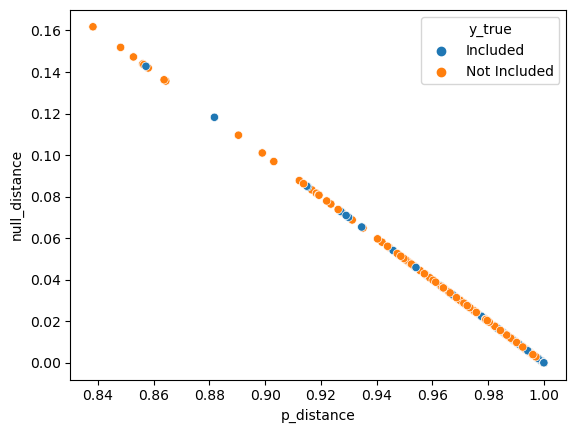

In [84]:
sns.scatterplot(data = df.iloc[1:,:], x = 'p_distance', y = 'null_distance', hue = 'y_true')

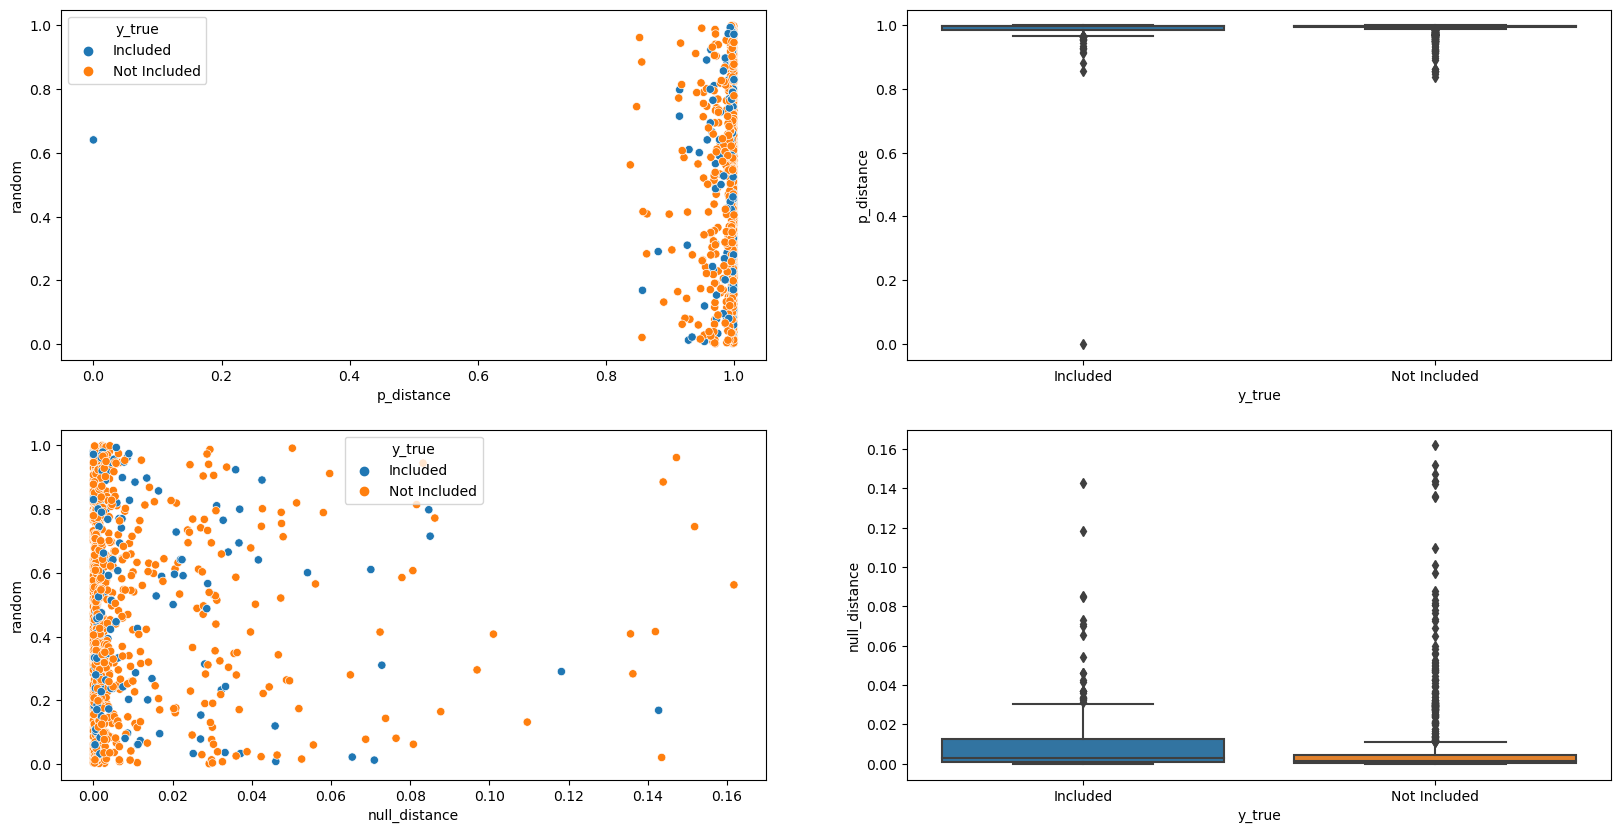

In [56]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10))
sns.scatterplot(data = df, x = 'p_distance', y = 'random', hue = 'y_true', ax = ax[0, 0])
sns.boxplot(data = df, x = 'y_true', y = 'p_distance', ax = ax[0, 1])
sns.scatterplot(data = df.iloc[1:,:], x = 'null_distance', y = 'random', hue = 'y_true', ax = ax[1, 0])
sns.boxplot(data = df.iloc[1:,:], x = 'y_true', y = 'null_distance', ax = ax[1, 1])


plt.show()

# Hypothesis Testing

#### Test 1

$$H_0 : \beta_0 = 0$$<br>
$$H_a : \beta_0\ne 0$$

In [134]:
p_distance = VI_p[0,0]
null_distance = VI_n[0,0]

In [135]:
p_distance, null_distance

(-2.384185791015625e-07, 0.9999999994471582)

#### Test 1

$$H_0 : \beta_0 + \beta_1 = 0$$<br>
$$H_a : \beta_0 + \beta_1\ne 0$$

In [136]:
# First check the parameter values
rg.config.coefficients['intercept'], rg.config.coefficients['X_0']

(4.380762177315919, -0.8483970769217306)

In [141]:
p_distance = mahalanobis(np.concatenate([np.ones(2), np.zeros(2**10-2)])/np.sqrt(2), np.zeros(2**10), VI_p)[0,0]
null_distance = mahalanobis(np.concatenate([np.ones(2), np.zeros(2**10-2)])/np.sqrt(2), np.zeros(2**10), VI_n)[0,0]


In [142]:
p_distance, null_distance

(0.7071066795860137, 0.7071066639132054)

#### Test 2

$$H_0 : \beta_0 + \beta_2 + \beta3 = 0$$<br>
$$H_a : \beta_0 + \beta_2 + \beta3 \ne 0$$

In [143]:
# First check the parameter values
rg.config.coefficients['intercept'], rg.config.coefficients['X_1'], rg.config.coefficients['X_2']

(4.380762177315919, 6.593377079696186, -5.770641385091155)

In [146]:
p_distance = mahalanobis(np.concatenate([np.array([1,0,1,1]), np.zeros(2**10-4)])/np.sqrt(3), np.zeros(2**10), VI_p)[0,0]
null_distance = mahalanobis(np.concatenate([np.array([1,0,1,1]), np.zeros(2**10-4)])/np.sqrt(3), np.zeros(2**10), VI_n)[0,0]

In [147]:
p_distance, null_distance

(0.8164377558997612, 0.577433865343027)

$$H_0 : \beta_0 + \beta_2 - \beta3 = 0$$<br>
$$H_a : \beta_0 + \beta_2 - \beta3 \ne 0$$

In [148]:
p_distance = mahalanobis(np.concatenate([np.array([1,0,1,-1]), np.zeros(2**10-4)])/np.sqrt(3), np.zeros(2**10), VI_p)[0,0]
null_distance = mahalanobis(np.concatenate([np.array([1,0,1,-1]), np.zeros(2**10-4)])/np.sqrt(3), np.zeros(2**10), VI_n)[0,0]


In [149]:
p_distance, null_distance

(0.8164377591819838, 0.577433735142761)